게임 판매량 예측하기

사용한 데이터셋 https://www.kaggle.com/datasets/gregorut/videogamesales

1. 라이브러리 불러오기

In [75]:
# 필요한 라이브러리 설치
!pip install pandas numpy matplotlib scikit-learn tensorflow graphviz

In [147]:
import pandas as pd
import numpy as np
import xgboost as xgb
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import Image

In [149]:
from xgboost import XGBRegressor

In [230]:
# 데이터 로드
url = "C:/Users/user/Downloads/vgsales.csv"
data = pd.read_csv(url)

In [232]:
data = data.drop(columns=["Unnamed: 0"], errors="ignore") #특징이 아닌 첫번째 데이터 삭제
data.head() #5번째 행까지 데이터 보기

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [234]:
print("\n데이터 요약 정보:\n")
print(data.info())  # 데이터 타입 확인


데이터 요약 정보:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None


In [236]:
print("\n기술 통계 정보:\n")
print(data.describe())  # 수치형 변수 통계


기술 통계 정보:

               Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
std     4791.853933      5.828981      0.816683      0.505351      0.309291   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4151.250000   2003.000000      0.000000      0.000000      0.000000   
50%     8300.500000   2007.000000      0.080000      0.020000      0.000000   
75%    12449.750000   2010.000000      0.240000      0.110000      0.040000   
max    16600.000000   2020.000000     41.490000     29.020000     10.220000   

        Other_Sales  Global_Sales  
count  16598.000000  16598.000000  
mean       0.048063      0.537441  
std        0.188588      1.555028  
min        0.000000      0.010000  
25%        0.000000      0.060000  
50%        0.010000      0.170000  
75%        0.040000     

2. 데이터 전처리

In [239]:
#결측치 확인
print(data.isnull().sum())

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


Year는 수치형 변수이므로, 결측치를 중앙값으로 대체.

In [242]:
data['Year'] = data['Year'].fillna(data['Year'].median())

publisher는 범주형 변수이므로, 결측치를 최빈값으로 대체.

In [245]:
# 최빈값(모드)으로 결측치 채우기
data['Publisher'] = data['Publisher'].fillna(data['Publisher'].mode()[0])

In [247]:
# 중복된 행 확인
duplicates = data.duplicated()
print(f"중복된 데이터 개수: {duplicates.sum()}")

중복된 데이터 개수: 0


In [249]:
# 불필요한 열 제거
data.drop(['Name'], axis=1, inplace=True)

In [251]:
# 범주형 데이터 원-핫 인코딩
categorical_cols = ['Platform', 'Genre', 'Publisher']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

훈련 데이터와 테스트 데이터 분할

In [254]:
# 특성 변수와 목표 변수 설정
X = data.drop(columns=["Global_Sales"])  # Global_Sales는 예측할 대상
y = data["Global_Sales"]  # Global_Sales가 목표 변수

In [256]:
# 데이터 분할 (훈련 데이터: 80%, 테스트 데이터: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [258]:
print("훈련 데이터 크기:", X_train.shape)
print("테스트 데이터 크기:", X_test.shape)

훈련 데이터 크기: (13278, 624)
테스트 데이터 크기: (3320, 624)


모델 학습

In [315]:
# 모델 초기화
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42
)

In [317]:
# 모델 학습
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [318]:
# 예측
y_pred_xgb = xgb_model.predict(X_test)

In [319]:
# 성능 평가 (MSE, R2)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [320]:
print("XGBoost Regressor MSE:", mse_xgb)
print("XGBoost Regressor R2:", r2_xgb)

XGBoost Regressor MSE: 0.7933507625129473
XGBoost Regressor R2: 0.8111682855947926


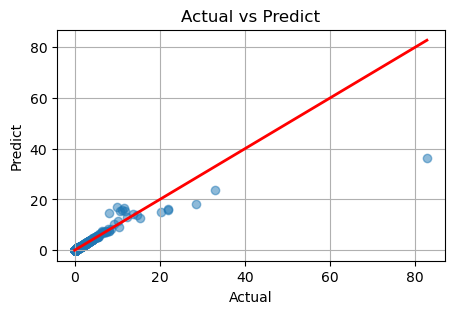

In [351]:
# 학습 결과 시각화
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title("Actual vs Predict")
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.grid()
plt.show()

In [361]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [378]:
import graphviz

# 모델을 Graphviz 형식으로 변환
dotfile = xgb.to_graphviz(xgb_model, num_trees=0)

# Graphviz 출력
dotfile.render("tree", format="png", cleanup=True)

# 이미지로 출력
Image("tree.png")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

chat GPT를 사용한 부분
- 데이터 전처리 과정
- xgb model 훈련 결과 시각화 코드